# Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy
import psycopg2
import datetime
from geopy import distance
import calendar
import folium
from folium.plugins import HeatMap
%matplotlib inline
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
df = pd.read_csv("analyze_me.csv")

In [3]:
df.head()

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,when_the_delivery_started,when_the_Jumpman_arrived_at_pickup,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff
0,1457973,327168,162381,van,Melt Shop,American,Lemonade,1.0,Beverages,00:19:58.582052,40.744607,-73.990742,40.752073,-73.985370,2014-10-26 13:51:59.898924,NaN,NaN,2014-10-26 14:52:06.313088
1,1377056,64452,104533,bicycle,Prince Street Pizza,Pizza,Neapolitan Rice Balls,3.0,Munchables,00:25:09.107093,40.723080,-73.994615,40.719722,-73.991858,2014-10-16 21:58:58.65491,2014-10-16 22:26:02.120931,2014-10-16 22:48:23.091253,2014-10-16 22:59:22.948873
2,1476547,83095,132725,bicycle,Bareburger,Burger,Bare Sodas,1.0,Drinks,00:06:44.541717,40.728478,-73.998392,40.728606,-73.995143,2014-10-28 21:39:52.654394,2014-10-28 21:37:18.793405,2014-10-28 21:59:09.98481,2014-10-28 22:04:40.634962
3,1485494,271149,157175,bicycle,Juice Press,Juice Bar,OMG! My Favorite Juice!,1.0,Cold Pressed Juices,NaN,40.738868,-74.002747,40.751257,-74.005634,2014-10-30 10:54:11.531894,2014-10-30 11:04:17.759577,2014-10-30 11:16:37.895816,2014-10-30 11:32:38.090061
4,1327707,122609,118095,bicycle,Blue Ribbon Sushi,Japanese,Spicy Tuna & Tempura Flakes,2.0,Maki (Special Rolls),00:03:45.035418,40.726110,-74.002492,40.709323,-74.015867,2014-10-10 00:07:18.450505,2014-10-10 00:14:42.702223,2014-10-10 00:25:19.400294,2014-10-10 00:48:27.150595


# Check Data Integrity

## 1) Check for missing values, data types and index

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5983 entries, 0 to 5982
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   delivery_id                          5983 non-null   int64  
 1   customer_id                          5983 non-null   int64  
 2   jumpman_id                           5983 non-null   int64  
 3   vehicle_type                         5983 non-null   object 
 4   pickup_place                         5983 non-null   object 
 5   place_category                       5100 non-null   object 
 6   item_name                            4753 non-null   object 
 7   item_quantity                        4753 non-null   float64
 8   item_category_name                   4753 non-null   object 
 9   how_long_it_took_to_order            3038 non-null   object 
 10  pickup_lat                           5983 non-null   float64
 11  pickup_lon                    

In [5]:
# Check for nulls
nulls = round(len(df) - df.count(),0)
total = len(df)
pct = round(nulls/total,2)
data = [nulls, pct]
data = pd.DataFrame(data).transpose()
data.rename(columns = {0:"nulls", 1:"pct"})

,nulls,pct
delivery_id,0.0,0.00
customer_id,0.0,0.00
jumpman_id,0.0,0.00
vehicle_type,0.0,0.00
pickup_place,0.0,0.00
place_category,883.0,0.15
item_name,1230.0,0.21
item_quantity,1230.0,0.21
item_category_name,1230.0,0.21
how_long_it_took_to_order,2945.0,0.49


In [6]:
# Rename some columns
df = df.rename(columns={
    "how_long_it_took_to_order": "ordering_time",
    "when_the_delivery_started": "delivery_start", 
    "when_the_Jumpman_arrived_at_pickup": "arrived_at_pickup",
    "when_the_Jumpman_left_pickup": "left_pickup",
    "when_the_Jumpman_arrived_at_dropoff": "dropoff"})

In [7]:
# Transform time-related columns to datetime dtype 
# Due to missing values, have to fill in NaT before converting
df.iloc[:,-4:] = df.iloc[:,-4:].fillna("NaT").astype("datetime64[ns]")
df["ordering_time"] = pd.to_timedelta(df.ordering_time.fillna("NaT"))

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5983 entries, 0 to 5982
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   delivery_id         5983 non-null   int64          
 1   customer_id         5983 non-null   int64          
 2   jumpman_id          5983 non-null   int64          
 3   vehicle_type        5983 non-null   object         
 4   pickup_place        5983 non-null   object         
 5   place_category      5100 non-null   object         
 6   item_name           4753 non-null   object         
 7   item_quantity       4753 non-null   float64        
 8   item_category_name  4753 non-null   object         
 9   ordering_time       3038 non-null   timedelta64[ns]
 10  pickup_lat          5983 non-null   float64        
 11  pickup_lon          5983 non-null   float64        
 12  dropoff_lat         5983 non-null   float64        
 13  dropoff_lon         5983 non-null

## 2) Check data reliability

In [9]:
print("Arrive before delivery starts:", df[df.arrived_at_pickup < df.delivery_start].delivery_id.count())
print("")
print("Leave before arriving:", df[df.left_pickup < df.arrived_at_pickup].delivery_id.count())
print("")
print("Leave before delivery starts:", df[df.left_pickup < df.delivery_start].delivery_id.count())
print("")
print("Drop off before pickup:", df[df.dropoff < df.left_pickup].delivery_id.count())

Arrive before delivery starts: 501

Leave before arriving: 0

Leave before delivery starts: 2

Drop off before pickup: 0


There are 501 rows where the Jumpmen arrived before the delivery even started, and 2 rows where delivery started after food pickup. How could this happen? Three possible reasons: 
- These are part of chained orders where the Jumpmen were making multiple deliveries in one trip. The orders came in when the Jumpmen are already at the restaurant picking up another order. 
- The app places the order ahead of time, then notifies Jumpmen. Jumpmen get there before the order is ready, which is when the delivery time starts. 
- Data logging/quality issue. For example, delivery_start and arrived_at_pickup could be a self-reported metric. 

First let's see if there are chained orders:

In [10]:
# Check for chained orders by zooming in on some of these cases
early = df[df.arrived_at_pickup < df.delivery_start]
early.sort_values(by = ["jumpman_id", "delivery_start"]).iloc[:, [0,1,2,3,4,10,11,14,15,16,17]].head(50)

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,pickup_lat,pickup_lon,delivery_start,arrived_at_pickup,left_pickup,dropoff
428,1357556,275241,3296,bicycle,NoHo Star,40.725906,-73.994757,2014-10-13 20:41:40.019897,2014-10-13 20:40:24.247736,2014-10-13 20:56:13.457190,2014-10-13 21:02:48.936157
2725,1392181,62929,3296,bicycle,La Esquina Taqueria,40.721354,-73.997525,2014-10-18 20:16:31.045442,2014-10-18 20:14:04.451942,2014-10-18 20:43:47.504755,2014-10-18 20:48:49.233466
2482,1474437,112483,3296,bicycle,CVS Pharmacy,40.688991,-73.992774,2014-10-28 16:41:16.925044,2014-10-28 16:40:40.544423,2014-10-28 16:48:30.993144,2014-10-28 16:53:08.437391
2613,1383663,367349,6873,car,Momofuku Milk Bar,40.714047,-73.954921,2014-10-17 20:52:48.346137,2014-10-17 20:52:19.500171,2014-10-17 21:00:10.737034,2014-10-17 21:05:32.902768
4460,1383663,367349,6873,car,Momofuku Milk Bar,40.714047,-73.954921,2014-10-17 20:52:48.346137,2014-10-17 20:52:19.500171,2014-10-17 21:00:10.737034,2014-10-17 21:05:32.902768
1648,1452247,397579,6873,car,Momofuku Milk Bar,40.714047,-73.954921,2014-10-25 21:23:54.474205,2014-10-25 21:21:37.332797,2014-10-25 21:46:27.157403,2014-10-25 21:57:45.197229
1568,1464116,54308,6873,car,Sant Ambroeus,40.723576,-73.996316,2014-10-26 20:49:02.071919,2014-10-26 20:46:36.712149,2014-10-26 21:22:26.158615,2014-10-26 21:28:07.342129
4757,1482915,403718,6873,car,Blue Ribbon Fried Chicken,40.724340,-73.990960,2014-10-29 21:24:35.105362,2014-10-29 21:23:21.354355,2014-10-29 21:44:11.266591,2014-10-29 21:50:02.836513
1904,1301033,193579,7833,bicycle,Momofuku Milk Bar,40.731795,-73.985673,2014-10-05 15:13:01.735740,2014-10-05 15:11:39.511053,2014-10-05 15:33:29.234096,2014-10-05 15:49:42.580307
5533,1302395,104801,7833,bicycle,Peacefood Cafe,40.785160,-73.976916,2014-10-05 17:46:55.529338,2014-10-05 17:46:44.330502,2014-10-05 17:58:05.582319,2014-10-05 18:05:01.911609


In [11]:
# Zoom in on a specific case
df[df.jumpman_id == 132725].sort_values(by = "delivery_start").iloc[4:6, [0,1,2,3,4,10,11,14,15,16,17]]

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,pickup_lat,pickup_lon,delivery_start,arrived_at_pickup,left_pickup,dropoff
4179,1299511,125854,132725,bicycle,Shake Shack,40.779126,-73.954905,2014-10-05 12:22:58.531953,2014-10-05 12:20:20.629888,2014-10-05 12:42:44.817788,2014-10-05 12:48:25.767423
4155,1299575,317660,132725,bicycle,Shake Shack,40.779126,-73.954905,2014-10-05 12:31:55.448330,2014-10-05 12:29:20.694267,2014-10-05 12:52:40.442684,2014-10-05 13:01:34.915575


In [12]:
# Zoom in on the two rows where delivery started after Jumpmen left the restaurant
df[df.left_pickup < df.delivery_start].iloc[:, [0,1,2,3,4,10,11,14,15,16,17]]

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,pickup_lat,pickup_lon,delivery_start,arrived_at_pickup,left_pickup,dropoff
623,1400134,54796,28765,bicycle,Postmates General Store (deprecated),40.714638,-74.008336,2014-10-19 17:05:12.398187,2014-10-19 17:02:58.656642,2014-10-19 17:04:48.283569,2014-10-19 17:51:52.966043
1478,1477564,83432,30905,car,300 North End Ave and Warren,40.716546,-74.014626,2014-10-28 23:55:37.796467,2014-10-28 23:53:13.673365,2014-10-28 23:54:33.478716,2014-10-29 00:08:40.906895


Based on the sequence of events, it doesn't seem like any of these orders are chained. We can only assume Jumpmen arrived ahead of the time, or Jumpmen/restaurants reported wrong time. 

Without knowing for sure how these timestamp columns are logged, just looking at each column's missing value count, it looks like delivery_start is a relatively reliable column, since every row has delivery_start recorded. However, we should proceed with caution with other timestamp columns, especially when calculating each step's time interval.

## 3) Check for redundant rows

In [13]:
print("Row count:", len(df))
print("")
print("Unique values:", df.nunique())

Row count: 5983

Unique values: delivery_id           5214
customer_id           3192
jumpman_id             578
vehicle_type             7
pickup_place           898
place_category          57
item_name             2277
item_quantity           11
item_category_name     767
ordering_time         2579
pickup_lat            1210
pickup_lon            1179
dropoff_lat           2841
dropoff_lon           2839
delivery_start        5214
arrived_at_pickup     4719
left_pickup           4717
dropoff               5214
dtype: int64


There are 5214 unique delivery_id, but 5983 rows in total in the dataframe. This is due to item breakout, meaning each row is an item. This means for further delivery analysis, we should create another dataframe where each row is a unique delivery_id.

# Data Manipulation

## 1) Add each step's time interval

Calculate delivery steps as defined here: https://blog.postmates.com/route-efficiencies-in-on-demand-delivery-741e4e227593

In [14]:
# Calculate pickup leg in minutes
pickup_leg = []
for index, row in df.iterrows():
    if pd.isnull(row.arrived_at_pickup) == True:
        pickup_leg.append(np.NaN)
    elif row.arrived_at_pickup >= row.delivery_start:
        pickup_leg.append(round((row.arrived_at_pickup - row.delivery_start).seconds/60,2))
    else:
        pickup_leg.append(0)
df["pickup_leg"] = pickup_leg

Due to the data issue pointed out above, for pickup_leg, there will be many negative intervals if we just do simple substraction, which isn't going to make any sense. Here we can hardcode them to be 0 for analysis purpose, since we assumed Jumpmen arrived before the order was ready.

In [15]:
# In minutes
df["ordering_time"] = round(df.ordering_time.dt.seconds/60,2)
df["total_delivery_time"] = round((df.dropoff - df.delivery_start).dt.seconds/60,2)
df["pickup_waypoint"] = round((df.left_pickup - df.arrived_at_pickup).dt.seconds/60,2)
df["dropoff_leg"] = round((df.dropoff - df.left_pickup).dt.seconds/60,2)

## 2) Create time-related variables

In [16]:
# Group time
df["delivery_date"] = df.delivery_start.dt.date
df["delivery_hour"] = df.delivery_start.dt.hour
df["weekday"] = df.delivery_start.dt.strftime('%A')

In [17]:
# Work hours flag - True if order happens during working hours
workday = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
df["work_hours_flag"] = (df.delivery_hour >= 10) & (df.delivery_hour < 17) & df.weekday.isin(workday)

In [18]:
# Peak hours flag - True if order happens during peak hours
peak_hours = [11,12,13,17,18,19,20,21] # total order count > 280
df["peak_hours_flag"] = df.delivery_hour.isin(peak_hours)

Peak hours are defined based on the order distribution over time (plotted under Exploratory Data Analysis section below) and this documentation: https://support.postmates.com/fleet/articles/115001300287-article-When-are-peak-hours-for-delivery-requests-

## 3) Calculate distance between pickup and dropoff

In [19]:
# Calculate distance

df["pickup_coords"] = list(zip(df.pickup_lat, df.pickup_lon))
df["dropoff_coords"] = list(zip(df.dropoff_lat, df.dropoff_lon))

dist = []
for index, row in df.iterrows():
    travel_dist = distance.distance(row["pickup_coords"], row["dropoff_coords"]).miles
    dist.append(travel_dist)

df["distance"] = dist

## 4) Create a new condensed dataframe

In [20]:
# Create a df for unique delivery ids

df2 = df.drop(["item_name", "item_quantity", "item_category_name"], axis=1)
df2.drop_duplicates(subset = "delivery_id", keep = "first", inplace = True)

print("row count:", len(df2))
print("")
print("unique values:", df2.nunique())

row count: 5214

unique values: delivery_id            5214
customer_id            3192
jumpman_id              578
vehicle_type              7
pickup_place            898
place_category           57
ordering_time           846
pickup_lat             1210
pickup_lon             1179
dropoff_lat            2841
dropoff_lon            2839
delivery_start         5214
arrived_at_pickup      4719
left_pickup            4717
dropoff                5214
pickup_leg             1819
total_delivery_time    2825
pickup_waypoint        1366
dropoff_leg            1612
delivery_date            30
delivery_hour            23
weekday                   7
work_hours_flag           2
peak_hours_flag           2
pickup_coords          1213
dropoff_coords         2849
distance               4703
dtype: int64


In [21]:
df2.head()

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,ordering_time,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,delivery_start,arrived_at_pickup,left_pickup,dropoff,pickup_leg,total_delivery_time,pickup_waypoint,dropoff_leg,delivery_date,delivery_hour,weekday,work_hours_flag,peak_hours_flag,pickup_coords,dropoff_coords,distance
0,1457973,327168,162381,van,Melt Shop,American,19.97,40.744607,-73.990742,40.752073,-73.985370,2014-10-26 13:51:59.898924,NaT,NaT,2014-10-26 14:52:06.313088,NaN,60.10,NaN,NaN,2014-10-26,13,Sunday,False,True,"(40.7446071410038, -73.99074196815491)","(40.7520725859369, -73.9853695545937)",0.587239
1,1377056,64452,104533,bicycle,Prince Street Pizza,Pizza,25.15,40.723080,-73.994615,40.719722,-73.991858,2014-10-16 21:58:58.654910,2014-10-16 22:26:02.120931,2014-10-16 22:48:23.091253,2014-10-16 22:59:22.948873,27.05,60.40,22.33,10.98,2014-10-16,21,Thursday,False,True,"(40.723079523456796, -73.9946150779724)","(40.719722, -73.991858)",0.273175
2,1476547,83095,132725,bicycle,Bareburger,Burger,6.73,40.728478,-73.998392,40.728606,-73.995143,2014-10-28 21:39:52.654394,2014-10-28 21:37:18.793405,2014-10-28 21:59:09.984810,2014-10-28 22:04:40.634962,0.00,24.78,21.85,5.50,2014-10-28,21,Tuesday,False,True,"(40.72847826361979, -73.99839183744791)","(40.728606, -73.995143)",0.170769
3,1485494,271149,157175,bicycle,Juice Press,Juice Bar,NaN,40.738868,-74.002747,40.751257,-74.005634,2014-10-30 10:54:11.531894,2014-10-30 11:04:17.759577,2014-10-30 11:16:37.895816,2014-10-30 11:32:38.090061,10.10,38.43,12.33,16.00,2014-10-30,10,Thursday,True,False,"(40.738867554505404, -74.0027474503103)","(40.7512572873763, -74.00563376031259)",0.868239
4,1327707,122609,118095,bicycle,Blue Ribbon Sushi,Japanese,3.75,40.726110,-74.002492,40.709323,-74.015867,2014-10-10 00:07:18.450505,2014-10-10 00:14:42.702223,2014-10-10 00:25:19.400294,2014-10-10 00:48:27.150595,7.40,41.13,10.60,23.12,2014-10-10,0,Friday,False,False,"(40.72610965706011, -74.0024918632005)","(40.7093232, -74.0158665)",1.354525


## 5) Create a repeat customer flag

In [22]:
# For each customer, rank orders by delivery time 
df2["order_rank"] = df2.groupby(by = "customer_id").delivery_start.rank(ascending = True, method = "dense")

# Get each customer's max order rank, if max > 1 then they are a repeat customer
lookup = df2.groupby(by = "customer_id").order_rank.max().reset_index()
lookup["repeat_customer_flag"] = lookup.order_rank > 1

# Join back on df2
df2 = df2.merge(lookup, on = "customer_id", how = "inner", suffixes=('', '_lookup'))
df2 = df2.drop(["order_rank_lookup"], axis=1)
df2.head()

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,ordering_time,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,delivery_start,arrived_at_pickup,left_pickup,dropoff,pickup_leg,total_delivery_time,pickup_waypoint,dropoff_leg,delivery_date,delivery_hour,weekday,work_hours_flag,peak_hours_flag,pickup_coords,dropoff_coords,distance,order_rank,repeat_customer_flag
0,1457973,327168,162381,van,Melt Shop,American,19.97,40.744607,-73.990742,40.752073,-73.985370,2014-10-26 13:51:59.898924,NaT,NaT,2014-10-26 14:52:06.313088,NaN,60.10,NaN,NaN,2014-10-26,13,Sunday,False,True,"(40.7446071410038, -73.99074196815491)","(40.7520725859369, -73.9853695545937)",0.587239,1.0,False
1,1377056,64452,104533,bicycle,Prince Street Pizza,Pizza,25.15,40.723080,-73.994615,40.719722,-73.991858,2014-10-16 21:58:58.654910,2014-10-16 22:26:02.120931,2014-10-16 22:48:23.091253,2014-10-16 22:59:22.948873,27.05,60.40,22.33,10.98,2014-10-16,21,Thursday,False,True,"(40.723079523456796, -73.9946150779724)","(40.719722, -73.991858)",0.273175,1.0,True
2,1412262,64452,113804,truck,Momofuku Milk Bar,Dessert,NaN,40.787150,-73.971722,40.784885,-73.953505,2014-10-20 22:41:48.533352,2014-10-20 22:46:16.817416,2014-10-20 23:03:03.967405,2014-10-20 23:14:13.281667,4.47,32.40,16.78,11.15,2014-10-20,22,Monday,False,False,"(40.7871496008661, -73.9717223121981)","(40.784885070705, -73.9535045816501)",0.968175,2.0,True
3,1448482,64452,174416,walker,Il Laboratorio Del Gelato,NaN,NaN,40.722501,-73.987126,40.722158,-73.985364,2014-10-25 16:35:06.108593,NaT,NaT,2014-10-25 17:04:47.543452,NaN,29.68,NaN,NaN,2014-10-25,16,Saturday,False,False,"(40.722501007878705, -73.9871264665896)","(40.722158, -73.985364)",0.095505,3.0,True
4,1476547,83095,132725,bicycle,Bareburger,Burger,6.73,40.728478,-73.998392,40.728606,-73.995143,2014-10-28 21:39:52.654394,2014-10-28 21:37:18.793405,2014-10-28 21:59:09.984810,2014-10-28 22:04:40.634962,0.00,24.78,21.85,5.50,2014-10-28,21,Tuesday,False,True,"(40.72847826361979, -73.99839183744791)","(40.728606, -73.995143)",0.170769,3.0,True


# Exploratory Data Analysis

## 1) Top-line Metrics

In [23]:
print("Total # of customers:", df2.customer_id.nunique())
print("Total # of deliveries:", df2.delivery_id.nunique())
print("Total # of Jumpmen:", df2.jumpman_id.nunique())
print("Total # of merchants:", df2.pickup_coords.nunique())
print("Avg deliveries per customer:", round(df2.delivery_id.nunique()/df2.customer_id.nunique(),2))
print("Avg deliveries per Jumpman:", round(df2.delivery_id.nunique()/df2.jumpman_id.nunique(),2))

Total # of customers: 3192
Total # of deliveries: 5214
Total # of Jumpmen: 578
Total # of merchants: 1213
Avg deliveries per customer: 1.63
Avg deliveries per Jumpman: 9.02


## 2) Customer Insights

In [24]:
# Order count distribution
order_count = lookup.groupby(by = "order_rank").customer_id.count().reset_index()
order_count = order_count.rename(columns = {"order_rank": "order_count",
                                 "customer_id": "customer_count"})
order_count

,order_count,customer_count
0,1.0,2216
1,2.0,512
2,3.0,232
3,4.0,106
4,5.0,54
5,6.0,29
6,7.0,14
7,8.0,7
8,9.0,6
9,10.0,5


In [25]:
# Count new VS repeat customers
customer_count = df2.groupby(by = "repeat_customer_flag").customer_id.nunique()
customer_pct = round(customer_count/(df2.customer_id.nunique()),2)
order_count = df2.groupby(by = "repeat_customer_flag").delivery_id.nunique()
order_pct = round(order_count/(df2.delivery_id.nunique()),2)
pd.DataFrame({"customer_count": customer_count, 
              "customer_pct": customer_pct,
              "order_count": order_count,
              "order_pct": order_pct})

,customer_count,customer_pct,order_count,order_pct
repeat_customer_flag,,,,
False,2216,0.69,2216,0.43
True,976,0.31,2998,0.57


While only 31% of the customers are repeat customers, they make up 57% of total order volume.

In [26]:
# Where do people like to order from? Top merchants/locations
top_places = df2.groupby(by = ["pickup_coords","pickup_place"]).delivery_id.nunique()
top_places = top_places.reset_index().iloc[:,1:]
top_25 = top_places.sort_values(by = "delivery_id", ascending = False).head(25)
print("Top 25 Merchants Order Sum:", top_25.delivery_id.sum())
top_25

Top 25 Merchants Order Sum: 1567


,pickup_place,delivery_id
237,Blue Ribbon Fried Chicken,115
270,Blue Ribbon Sushi,111
409,Momofuku Milk Bar,96
93,Shake Shack,90
214,Parm,89
712,sweetgreen,80
300,Mighty Quinn's BBQ,72
1131,RedFarm Broadway,70
332,Momofuku Noodle Bar,69
169,sweetgreen,58


Top 2% (25) merchants boast a whooping 30% of deliveries collectively!

In [27]:
# What do people like to order? Top place categories
top_cats = df2.groupby(by = ["place_category"]).delivery_id.nunique().reset_index()
top_10_cats = top_cats.sort_values(by = "delivery_id", ascending = False).head(10)
print("Top 10 Categories Order Sum:", top_10_cats.delivery_id.sum())
top_10_cats

Top 10 Categories Order Sum: 2756


,place_category,delivery_id
30,Italian,437
9,Burger,395
1,American,357
31,Japanese,335
17,Dessert,277
11,Chinese,265
52,Sushi,203
44,Salad,192
36,Mexican,165
27,Grocery Store,130


Top 10 categories account for 53% of total deliveries! Looks like New Yorks' tastes are not that diverse after all.

In [28]:
# When are people ordering? Order distribution over time
order_time = df2.groupby(by = ["weekday","delivery_hour"]).delivery_id.count().to_frame()
order_time

delivery_id
weekday   delivery_hour             
Friday    0                       16
          1                        1
          2                        1
          7                        5
          8                        1
          9                        6
          10                      25
          11                      43
          12                      52
          13                      44
          14                      27
          15                      29
          16                      27
          17                      39
          18                      76
          19                     109
          20                      97
          21                      67
          22                      28
          23                      19
Monday    0                        6
          1                        4
          2                        4
          3                        1
          7                        2
          8                        5
          9                        8
          10                      20
          11                      31
          12                      45
          13                      38
          14                      20
          15                      13
          16                      25
          17                      40
          18                      78
          19                      99
          20                      72
          21                      59
          22                      21
          23                      17
Saturday  0                        8
          1                        7
          2                        6
          3                        3
          4                        2
          7                        1
          8                        1
          9                       11
          10                      14
          11                      32
          12                      40
          13                      39
          14                      43
          15                      40
          16                      48
          17                      65
          18                      89
          19                      90
          20                      91
          21                      55
          22                      32
          23                      21
Sunday    0                       13
          1                        7
          2                        5
          3                        2
          4                        2
          7                        3
          8                        4
          9                       18
          10                      31
          11                      48
          12                      56
          13                      54
          14                      51
          15                      49
          16                      62
          17                      93
          18                     140
          19                     122
          20                      88
          21                      57
          22                      25
          23                      17
Thursday  0                        8
          1                        6
          2                        1
          4                        1
          7                        2
          8                        4
          9                       15
          10                      22
          11                      45
          12                      63
          13                      48
          14                      32
          15                      37
          16                      30
          17                      48
          18                      94
          19                     134
          20                     100
          21                      59
          22                      31
          23                      12
Tuesday   0                  

Visualization of this data is done in Google Sheet. After plotting it out, it's pretty obvious every day lunch and dinner time, and weekends are the busiest hours.

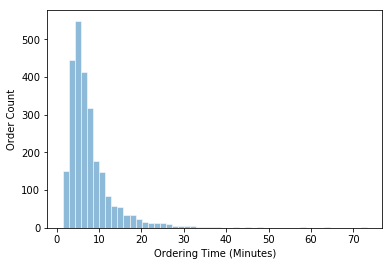

Average Ordering Time: 7.69
Median Ordering Time: 6.15


In [29]:
# Ordering time distribution
plt.hist(df2.ordering_time[df2.ordering_time>=0], bins = 50, alpha=0.5, histtype='bar', ec='white')
plt.xlabel("Ordering Time (Minutes)")
plt.ylabel("Order Count")
plt.show()
print("Average Ordering Time:", round(df2.ordering_time.mean(),2))
print("Median Ordering Time:", round(df2.ordering_time.median(),2))

It took some people a long time to place an order. This could be a signal of room for improvement in the app's experience.

## 3) Operations Insights

### Delivery Time Analysis

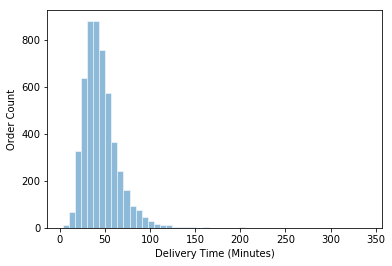

In [30]:
# Check delivery time distribution
plt.hist(df2.total_delivery_time, bins = 50, alpha=0.5, histtype='bar', ec='white')
plt.xlabel("Delivery Time (Minutes)")
plt.ylabel("Order Count")
plt.show()

If we plot out the distribution for each step, we will notice the data has pretty big variance with some deliveries taking very long time, driving up the averages. Therefore it also makes sense to measure the medians for these intervals, for analysis purpose.

In [31]:
# Check avgs
print("Avg delivery time:", round(df2.total_delivery_time.mean(),2))
print("Avg pickup leg:", round(df2.pickup_leg.mean(),2))
print("Avg pickup waypoint:", round(df2.pickup_waypoint.mean(),2))
print("Avg dropoff leg:", round(df2.dropoff_leg.mean(),2))

Avg delivery time: 45.21
Avg pickup leg: 12.72
Avg pickup waypoint: 18.29
Avg dropoff leg: 14.03


In [32]:
# Check medians
print("Median delivery time:", round(df2.total_delivery_time.median(),2))
print("Median pickup leg:", round(df2.pickup_leg.median(),2))
print("Median pickup waypoint:", round(df2.pickup_waypoint.median(),2))
print("Median dropoff leg:", round(df2.dropoff_leg.median(),2))

Median delivery time: 42.01
Median pickup leg: 9.87
Median pickup waypoint: 15.33
Median dropoff leg: 11.65


The biggest bottleneck in the whole delivery process is pickup_waypoint. It looks like Jumpmen spent a lot time just waiting around for the order to be ready.

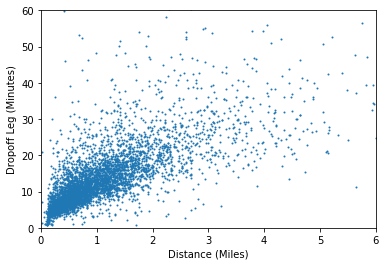

In [33]:
# Check correlation of pickup-dropoff distance and delivery time:

plt.scatter(x = df2.distance, y = df2.dropoff_leg, data = df2, s = 1)
plt.ylim([0, 60])
plt.xlim([0, 6])
plt.xlabel("Distance (Miles)")
plt.ylabel("Dropoff Leg (Minutes)")

plt.show()

Apparently the longer the distance, the longer it takes the Jumpmen to travel to. There are some extreme values that are cut off from this plot. If we could put a cap on delivery distance, we can optimize delivery time by a lot.

### Jumpmen Operations

In [34]:
# Distribution of # of deliveries by each jumpman
jumpman = df2.groupby(by = "jumpman_id").delivery_id.count().sort_values(ascending = True).to_frame(name = "order_count")
print("Avg # of deliveries per Jumpman:", round(jumpman.order_count.mean()))
print("Top 10% Jumpmen delivered:", jumpman.sort_values(by = "order_count", ascending = False).head(60).order_count.sum())
print("# of Jumpmen who completed under 10 deliveries:", jumpman.query("order_count < 10").order_count.count())

Avg # of deliveries per Jumpman: 9
Top 10% Jumpmen delivered: 1994
# of Jumpmen who completed under 10 deliveries: 387


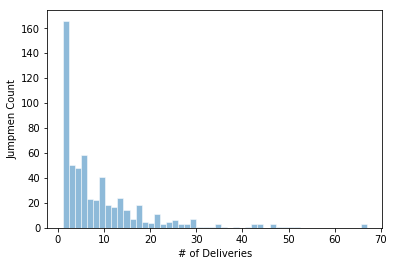

In [35]:
plt.hist(jumpman.order_count, bins = 50, alpha=0.5, histtype='bar', ec='white')
plt.xlabel("# of Deliveries")
plt.ylabel("Jumpmen Count")
plt.show()

Majority of Jumpmen completed only under 10 deliveries in the month. This means we might have a lot of inexperienced Jumpmen.

### Peak Hours Operations

In [36]:
df2.groupby(by = "peak_hours_flag").agg({"total_delivery_time": np.median,
                                        "pickup_leg": np.median,
                                        "pickup_waypoint": np.median,
                                        "dropoff_leg": np.median})

,total_delivery_time,pickup_leg,pickup_waypoint,dropoff_leg
peak_hours_flag,,,,
False,39.33,7.62,15.25,11.27
True,42.85,10.79,15.33,11.81


In [37]:
# Check supply and demand during and off peak hours
delivery_count = df2.groupby(by = "peak_hours_flag").delivery_id.nunique()
jumpman_count = df2.groupby(by = "peak_hours_flag").jumpman_id.nunique()
deliveries_per_jumpman = round(delivery_count/jumpman_count,2)
pd.DataFrame({"delivery_count": delivery_count, 
              "jumpman_count": jumpman_count,
              "deliveries_per_jumpman": deliveries_per_jumpman})

,delivery_count,jumpman_count,deliveries_per_jumpman
peak_hours_flag,,,
False,1441,373,3.86
True,3773,542,6.96


pickup_leg is longer during peak hours. This means Jumpmen are not close enough to the pickup places, thus can't get to pickup places quickly. It also looks like we don't have enough supply of Jumpmen during peak hours, with each Jumpman having to handle 7 deliveries on average.

We need more Jumpmen during peak hours, and dispatch/guide jumpmen to the busy areas ahead of time, which could be assisted with the heatmap created under Map Visualization section below.

### Map Visualization

Based on the operations insights above, in order to optimize delivery time, there are a few things we can do:

1) Implement a cap on delivery distance, which also means we need to...

2) Make sure there are enough merchants near customers

3) Dispatch Jumpmen to the busy areas close to the merchants ahead of delivery

Spatial visualization of the current geographic distribution of supply and demand will help us achieve these goals.


In [38]:
# Create a dataframe for restaurants

order_count = df2.groupby(by = ["pickup_place", "pickup_lat", "pickup_lon"]).delivery_id.count()
df_restaurant = order_count.reset_index()
df_restaurant = df_restaurant.rename(columns = {"delivery_id": "order_count"})
df_restaurant.head()

,pickup_place,pickup_lat,pickup_lon,order_count
0,Il Mulino New York,40.729951,-73.999027,1
1,Il Mulino New York,40.764102,-73.970408,1
2,$10 Blue Ribbon Fried Chicken Sandwich,40.724340,-73.990960,25
3,'Essen,40.759766,-73.973921,1
4,'wichcraft,40.739386,-73.990185,1


In [39]:
# Create a dataframe for customers

order_count = df2.groupby(by = ["dropoff_lat", "dropoff_lon"]).delivery_id.count()
df_customer = order_count.reset_index()
df_customer = df_customer.rename(columns = {"delivery_id": "order_count"})
df_customer.head()

,dropoff_lat,dropoff_lon,order_count
0,40.649356,-73.964463,1
1,40.649404,-73.964427,1
2,40.649574,-73.964392,1
3,40.652145,-73.957812,1
4,40.666888,-73.977248,1


In [40]:
# Create a heatmap for restaurants

hmap_restaurant = folium.Map(location=[40.738, -73.98],
                        zoom_start=12.4,
                        tiles="CartoDB dark_matter",
                        width='50%')

hm = HeatMap(list(zip(df_restaurant.pickup_lat, df_restaurant.pickup_lon, df_restaurant.order_count)),
                  min_opacity=.6,
                  max_val=1,
                  radius=6, 
                  blur=1, 
                  gradient = {0.3: "#F25278", 0.6: "#FE7F9C", 0.9: "#FDA4BA", 1: "#FFFFFF"}
                 )

hmap_restaurant = hmap_restaurant.add_child(hm)

In [43]:
# Add markers for top 10 restaurants in the data

top10 = df_restaurant.sort_values(by = "order_count", ascending = False).head(10)

for index, row in top10.iterrows():

    # generate the popup message that is shown on click.
    popup_text = "{}<br> order count: {}"
    popup_text = popup_text.format(row.pickup_place,
                                   row.order_count)

    # add marker to the map
    folium.Marker(location=(row.pickup_lat, row.pickup_lon),
                        icon=folium.Icon(icon = 'star', color='lightblue', prefix='fa'),
                        popup=popup_text,
                 ).add_to(hmap_restaurant)

hmap_restaurant

In [44]:
# Create a heatmap for customers

hmap_customer = folium.Map(location=[40.75, -73.98],
                        zoom_start=12.4,
                        tiles="CartoDB dark_matter",
                        width='50%')

hm2 = HeatMap(list(zip(df_customer.dropoff_lat, df_customer.dropoff_lon, df_customer.order_count)),
                  min_opacity=.5,
                  max_val=1,
                  radius=6, 
                  blur=1, 
                  gradient = {0.3: "#3944BC", 0.6: "#0492C2", 0.95: "#63C5DA", 1: "#E8FFFF"}
                 )

hmap_customer.add_child(hm2)

It does look like there is mismatch between supply and demand in certain neighhoods: Upper East Side, Upper West Side, Midtown West, Williamsburg. In order to deliver to customers in these neighborhoods, Jumpmen have to travel farther which means longer delivery time.

Next step, we can create heatmaps with different times during the day to show how demand and supply shift dynamically. And then, we can share these time-based heatmaps with Jumpmen so they know exactly where to go and when to go.